# This file is seeing what we get when we just apply the Random Forest directly to the Time Series

In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
from rfgap import RFGAP


# Get the data
sys.path.insert(0, '/yunity/arusty/PF-GAP')

static2024 = pd.read_csv('../data/static2024.csv')
static2023 = pd.read_csv('../data/static2023.csv')
time_series = pd.read_csv('../data/time_series.csv')
labels = pd.read_csv('../data/labels.csv')


In [2]:
# Combine the static data with the time series data
static2024.shape, time_series.shape

((503, 11), (503, 829))

In [3]:
train = np.concat([time_series, static2024], axis=1)
train.shape

(503, 840)

In [4]:
rfgap = RFGAP(prediction_type="classification", y = labels, oob_score = True)
rfgap.fit(train, labels)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [5]:
rfgap.oob_score_

0.7872763419483101

In [6]:
rfgap.get_proximities().todense()

matrix([[0.        , 0.00361618, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01389695, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.01578533,
         0.01735487],
        ...,
        [0.00174216, 0.00119122, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00900901, 0.00926503, ..., 0.        , 0.        ,
         0.        ],
        [0.00157604, 0.00137268, 0.00714226, ..., 0.00101317, 0.00077369,
         0.        ]])

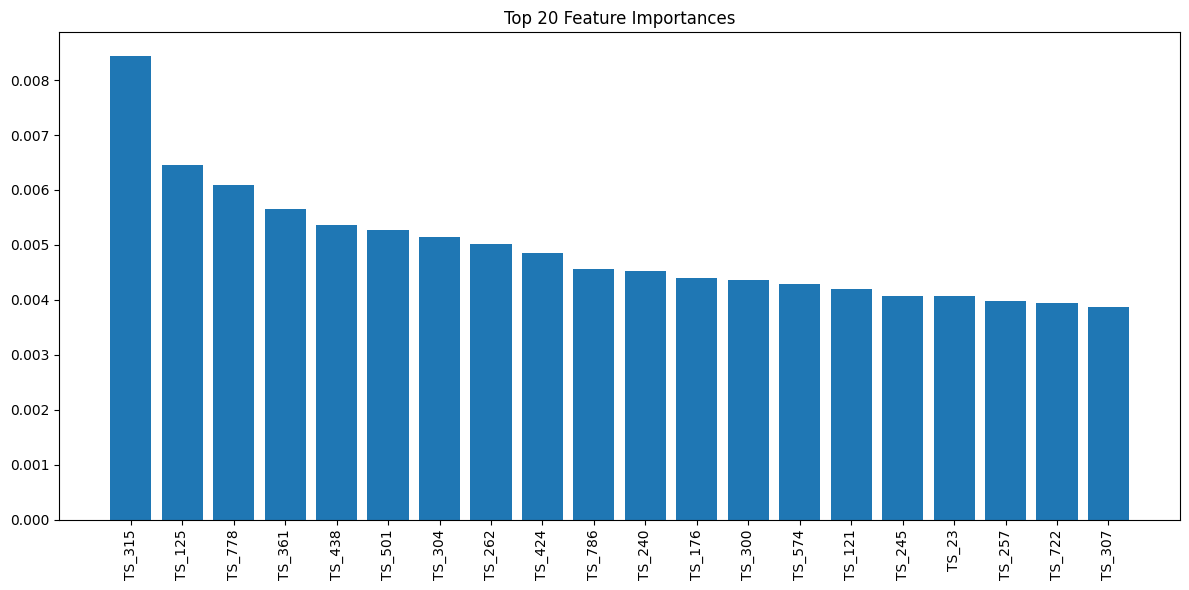

In [7]:
import matplotlib.pyplot as plt

# Get feature importances from the fitted rfgap model
importances = rfgap.feature_importances_

# Create feature names: static + time series
static_features = list(static2024.columns)
time_series_features = [f"TS_{col}" for col in time_series.columns]
feature_names = time_series_features + static_features

# Plot
plt.figure(figsize=(12, 6))
indices = np.argsort(importances)[::-1][:20]  # Top 20 features

# Color bars orange if in the last 11 features, else blue
bar_colors = [
    'orange' if indices[i] >= len(feature_names) - 11 else 'C0'
    for i in range(len(indices))
]

plt.bar(range(len(indices)), importances[indices], color=bar_colors)
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Setting this up to get test results

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test, static2023_train, static2023_test, static2024_train, static2024_test = train_test_split(time_series, 
labels, static2023, static2024, test_size=0.2, random_state=42)

X_train = np.concat([X_train, static2023_train], axis=1)
X_test = np.concat([X_test, static2024_test], axis=1)

# Fit the model on the training set
rfgap.fit(X_train, y_train)

# Optionally, check OOB score or make predictions on X_test
print("OOB Score:", rfgap.oob_score_)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


OOB Score: 0.7661691542288557


In [18]:
prox_train = np.array(rfgap.get_proximities().todense())
prox_test = np.array(rfgap.prox_extend(X_test).todense())

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# Use the proximity matrices as features for KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(prox_train, y_train)
knn.score(prox_test, y_test)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7029702970297029